## Library Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
df_purchase = pd.read_csv('purchase data.csv')

## Data Exploration

In [3]:
df_purchase.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,0,47,1,110866,1,0


## Data Segmentation

### Import Segmentation model

In [4]:
scaler = pickle.load(open('scaler.pickle','rb'))

In [5]:
pca = pickle.load(open('pca.pickle','rb'))

In [6]:
kmeans_pca = pickle.load(open('kmeans_pca.pickle','rb'))

### Standardization

In [7]:
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income','Occupation', 'Settlement size']]
df_purchase_seg_std = scaler.transform(features)

### PCA 

In [8]:
df_purchase_seg_pca = pca.transform(df_purchase_seg_std)

### K-means PCA

In [9]:
df_purchase_seg_kmeans_pca = kmeans_pca.predict(df_purchase_seg_pca)

In [10]:
df_purchase_predictors = df_purchase.copy()

In [11]:
df_purchase_predictors['Segment'] = df_purchase_seg_kmeans_pca

## Descriptive Analysis
---
### Data Analysis by Customer

In [12]:
df_purchase_predictors.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,0,0,0,0,47,1,110866,1,0,3
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,3
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,3
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,0,0,0,0,47,1,110866,1,0,3
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,0,0,0,0,47,1,110866,1,0,3


In [13]:
n_visits = df_purchase_predictors[['ID','Incidence']].groupby(['ID'], as_index=False).count()
n_visits = n_visits.set_index('ID')
n_visits = n_visits.rename(columns={'Incidence':'N_Visits'})
n_visits.head()

,N_Visits
ID,
200000001,101
200000002,87
200000003,97
200000004,85
200000005,111


In [14]:
n_purchase = df_purchase_predictors[['ID','Incidence']].groupby(['ID'], as_index=False).sum()
n_purchase = n_purchase.set_index('ID')
n_purchase = n_purchase.rename(columns={'Incidence':'N_Purchase'})
n_purchase.head()

,N_Purchase
ID,
200000001,9
200000002,11
200000003,10
200000004,11
200000005,13


In [15]:
da_tab = n_visits.join(n_purchase)
da_tab['Purchase_Prop'] = da_tab['N_Purchase'] /da_tab['N_Visits']
da_tab.head()

,N_Visits,N_Purchase,Purchase_Prop
ID,,,
200000001,101,9,0.089109
200000002,87,11,0.126437
200000003,97,10,0.103093
200000004,85,11,0.129412
200000005,111,13,0.117117


In [16]:
cust_seg = df_purchase_predictors[['ID','Segment']].groupby(['ID'], as_index=False).mean()
cust_seg = cust_seg.set_index('ID')
df_purchase_desc = da_tab.join(cust_seg)

In [17]:
df_purchase_desc.head()

,N_Visits,N_Purchase,Purchase_Prop,Segment
ID,,,,
200000001,101,9,0.089109,3
200000002,87,11,0.126437,2
200000003,97,10,0.103093,3
200000004,85,11,0.129412,3
200000005,111,13,0.117117,0


### Segment Proportions

In [18]:
seg_prop = df_purchase_desc[['N_Purchase','Segment']].groupby(['Segment']).count()/ da_tab.shape[0]
seg_prop = seg_prop.rename(columns={'N_Purchase':'Segment_Prop'})

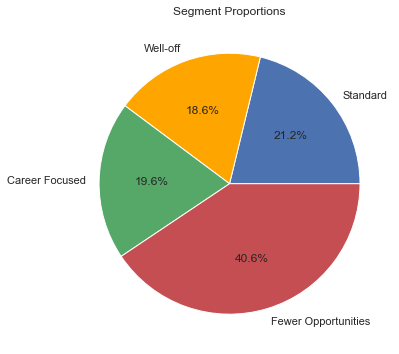

In [19]:
plt.figure(figsize=(9,6))
plt.title('Segment Proportions')
plt.pie(seg_prop['Segment_Prop'], 
        labels=['Standard','Well-off','Career Focused','Fewer Opportunities'],
       autopct='%1.1f%%', 
       colors = ('b','orange','g','r'))
plt.show()

***Customers in Fewer Opportunities Segment have the highest number of transactions***

In [20]:
seg_mean = df_purchase_desc.groupby('Segment').mean()
seg_std = df_purchase_desc.groupby('Segment').std()

Text(0.5, 1.0, 'Average Number of Store Visits by Segment')

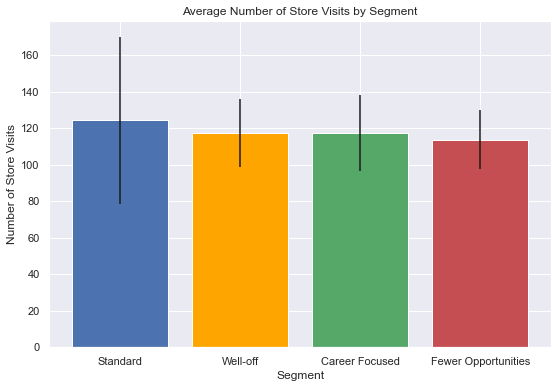

In [21]:
plt.figure(figsize=(9,6))
plt.bar(x = (0,1,2,3),
       tick_label = ('Standard','Well-off','Career Focused','Fewer Opportunities'),
       height = seg_mean['N_Visits'],
       yerr = seg_std['N_Visits'],
       color = ('b','orange','g','r'))
plt.xlabel('Segment')
plt.ylabel('Number of Store Visits')
plt.title('Average Number of Store Visits by Segment')

### Describe the charts

Text(0.5, 1.0, 'Number of Purchases by Segment')

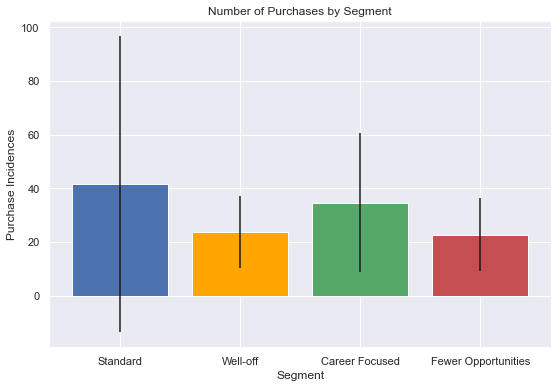

In [22]:
plt.figure(figsize=(9,6))
plt.bar(x = (0,1,2,3),
       tick_label = ('Standard','Well-off','Career Focused','Fewer Opportunities'),
       height = seg_mean['N_Purchase'],
       yerr = seg_std['N_Purchase'],
       color = ('b','orange','g','r'))
plt.xlabel('Segment')
plt.ylabel('Purchase Incidences')
plt.title('Number of Purchases by Segment')

### Describe the Charts, club them side by side

## Brand Choice

In [23]:
df_purchase_incidence = df_purchase_predictors[df_purchase_predictors['Incidence'] == 1]

In [24]:
brand_dummies = pd.get_dummies(df_purchase_incidence['Brand'],
                              prefix='Brand',
                              prefix_sep='_')
brand_dummies['Segment'],brand_dummies['ID'] = df_purchase_incidence['Segment'],df_purchase_incidence['ID'] 

In [25]:
temp = brand_dummies.groupby(['ID'], as_index=True).mean()

In [26]:
mean_brand_choice = temp.groupby(['Segment'], as_index=True).mean()

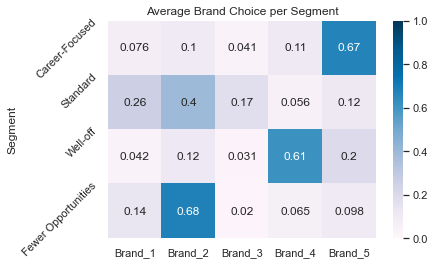

In [27]:
sns.heatmap(mean_brand_choice, 
           annot=True,
           vmin=0,
           vmax=1,
           cmap='PuBu')
plt.title('Average Brand Choice per Segment')
plt.yticks([0,1,2,3],
          ['Career-Focused','Standard','Well-off','Fewer Opportunities'],
          rotation = 45)
plt.show()

***P.S - Brands are ordered from Cheap to Expensive (Left to Right)***

*Career focused and Well-off segment like the expensive brand chocolates,
Standard customers are scattered heterogenously along the scale.*

## Revenue by Segment

In [43]:
%%capture
brands = [1,2,3,4,5]
seg_brand_rev = pd.DataFrame()

for i in brands:
    # create a temp dataset for a particular brand
    temp = df_purchase_predictors[df_purchase_predictors['Brand'] == i]
    
    str_ind = str(i)
    brand_name = 'Rev_Brand_'+str_ind
    brand_price = 'Price_'+str_ind
    
    # calculate revenue per brand/per segment
    temp.loc[:,brand_name] = temp[brand_price].multiply(temp['Quantity'])
    seg_brand_rev[['Segment',brand_name]] = temp[['Segment',brand_name]].groupby(['Segment'], as_index=False).sum() 

In [39]:
seg_brand_rev['Total_Revenue'] = (seg_brand_rev['Rev_Brand_1'] +
                                 seg_brand_rev['Rev_Brand_2'] +
                                 seg_brand_rev['Rev_Brand_3'] +
                                 seg_brand_rev['Rev_Brand_4'] +
                                 seg_brand_rev['Rev_Brand_5'])

In [40]:
seg_brand_rev['Seg_proportions'] = seg_prop['Segment_Prop']
seg_brand_rev['Segment'] = seg_brand_rev['Segment'].map({
                                                        0:'Career-Focused',
                                                        1:'Standard',
                                                        2:'Well-off',
                                                        3:'Fewer Opportunities'})
seg_brand_rev = seg_brand_rev.set_index(['Segment'])

seg_brand_rev

,Rev_Brand_1,Rev_Brand_2,Rev_Brand_3,Rev_Brand_4,Rev_Brand_5,Total_Revenue,Seg_proportions
Segment,,,,,,,
Career-Focused,705.96,1151.70,650.32,2301.70,20251.43,25061.11,0.212
Standard,2490.83,4140.54,3909.17,628.74,1479.29,12648.57,0.186
Well-off,699.47,1298.23,731.35,14185.57,5509.69,22424.31,0.196
Fewer Opportunities,2409.39,15177.84,730.68,1924.09,2380.59,22622.59,0.406


***Output***

1. *Career-focused segment generate the most revenue, majority from brand 5*
2. *Standard segement spend their money on lower end brands 1,2,3*
3. *Well-off customers are hooked on brand 4 and somewhat to brand 5*
4. *The last segment customers spend most of their money on Brand 2*